In [1]:
import h5py
import numpy as np
from tqdm import tqdm
from pathlib import Path
from scipy.stats import norm
from utils.plot_utils import *
import matplotlib.pyplot as plt
from astropy import units, constants
from scipy.interpolate import griddata

In [2]:
from julia import Main

In [3]:
Main.eval("Threads.nthreads()")

10

## Velocity Broadening
The beamsource can be modelled as an extended source, spawning molecules in a 2D gaussian distribution with width $\sigma = 4.83 mm$ at 1 cm from the cell opening.  
From Oskari's beamsource characterization report the forward velocity is 184 m/s $\pm$ 16.8 m/s, width a transverse velocity $\sigma_\perp = 93/2\sqrt{2}\log{2}$ m/s.  

The Doppler shift in frequency is given by $f = f_0 \left(1+v/c\right)$, where $f_0$ is the rest frequency.

In [4]:
@units.quantity_input
def doppler_shift(v: units.m/units.s, frequency: units.Hz):
    return (frequency*(1+v/constants.c)).to(units.Hz)

In [5]:
Γ = (1/(100*units.ns)).to(units.Hz)
vp = 1*units.m/units.s
ω = (2*np.pi*constants.c/(271*units.nm)).to(units.Hz)

In [6]:
v_to_Γ = (doppler_shift(vp,ω) - ω)/Γ
print(f'1 m/s transverse velocity results in a frequency shift of {v_to_Γ:.2f} Γ')

1 m/s transverse velocity results in a frequency shift of 2.32 Γ


The rotational cooling detection scheme has 2 apertures with a radius of 4 mm, one placed before the rotational cooling chamber and another before the detection chamber.

Now spawning the molecules with random positions and velocities, drawn from gaussian distributions.

In [7]:
# from Oskari's Beam Characterization report
vcm = 184
vcm_sigma = 16.8
vt_sigma = 93/(2*np.sqrt(2*np.log(2))) # from FWHM

# coordinate width, adapted from ACME to CeNTREX based on email from Xing Wu on 6-10-2020
sigma_width = 0.25*25.4/5 * 3.8e-3

v_acceptable = 1.5 # m/s

v_laser = 1.5 # m/s, molecules the laser can interact with
r_laser = 5e-3 # m

In [8]:
generate_random_r = lambda x: np.random.normal(0,sigma_width,x)
generate_random_longitudinal_velocities = lambda x: np.random.normal(vcm, vcm_sigma, x)

def generate_random_coords(size):
    xy = np.empty([2,size])
    xy[0,:] = generate_random_r(size)
    xy[1,:] = generate_random_r(size)
    return xy
            
def generate_random_transverse_velocities(size):
    v_transverse = np.random.multivariate_normal([0,0],np.array([[vt_sigma**2,0],[0,vt_sigma**2]]),size).T
    return v_transverse

In [9]:
np.random.seed(42)
size = int(1e8)
coords = generate_random_coords(size)
v_z = generate_random_longitudinal_velocities(size)
v_x, v_y = generate_random_transverse_velocities(size)

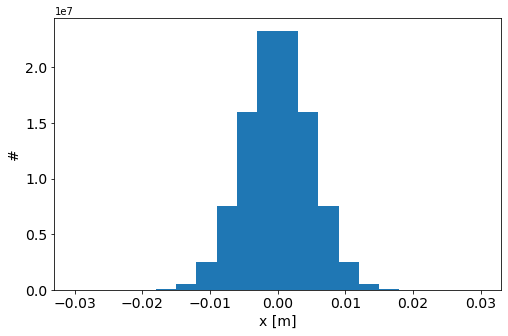

In [10]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(coords[0,:], bins = np.linspace(-0.03, 0.03, 21))
ax.set_xlabel('x [m]')
ax.set_ylabel('#')

set_fontsize(ax, 14)

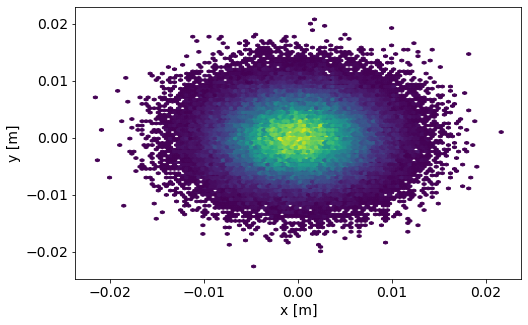

In [11]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hexbin(coords[0,:][:int(1e5)],coords[1,:][:int(1e5)], mincnt = 1)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

set_fontsize(ax, 14)

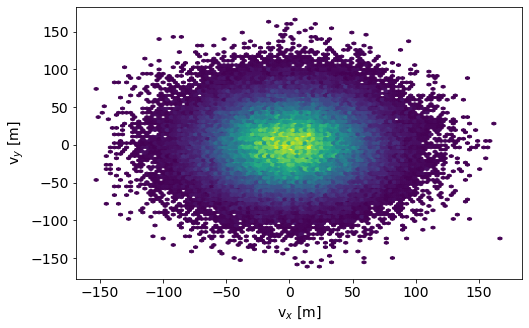

In [12]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hexbin(v_x[:int(1e5)], v_y[:int(1e5)], mincnt = 1)
ax.set_xlabel(r'v$_x$ [m]')
ax.set_ylabel(r'v$_y$ [m]')

set_fontsize(ax, 14)

### Without Aperture
Without an aperture there are several transverse velocity limiting components in the beamline.  
The closest to the rotational cooling chamber is the entrance flange, where the 1st colimator would also be placed.
The distance from the assumed extended source of this component is 17.36" - 1 cm, and the opening diameter is 60 mm.

In [13]:
in_to_m = (units.imperial.inch).to(units.m)

In [14]:
distance_aperture_1 = 17.36 * in_to_m - 0.01

filtered = np.empty([3,size])

dt = distance_aperture_1/v_z
filtered[0,:] = coords[0,:]+dt*v_x
filtered[1,:] = coords[1,:]+dt*v_y
filtered[2,:] = distance_aperture_1

m = np.sqrt(np.sum(filtered[:2,:]**2, axis = 0)) < 60/2 * 1e-3
size = m.sum()

v_x_full, v_y_full, v_z_full = v_x.copy(), v_y.copy(), v_z.copy()
v_x, v_y, v_z = v_x[m], v_y[m], v_z[m]

coords_full = coords.copy()
coords = np.empty([2,size])
coords[0,:] = coords_full[0,:][m]
coords[1,:] = coords_full[1,:][m]

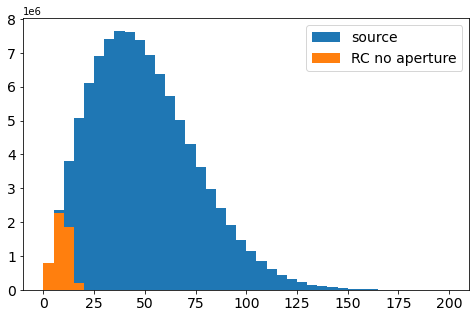

In [15]:
dx = 5
b = np.arange(0,200+dx,dx)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.sqrt(v_x_full**2+v_y_full**2), bins = b, label = 'source')
ax.hist(np.sqrt(v_x**2+v_y**2), bins = b, label = 'RC no aperture')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

distance to RC laser from cell opening is 21.75"  
distance to aperture #1 from cell opening is 17.36"  

distance to LIF laser from cell opening is 38.39"  
distance to aperture #2 from cel opening is 35.37" 

In [16]:
distance_aperture_1 = 17.36 * in_to_m - 0.01

coords_aperture_1 = np.empty([3,size])

dt = distance_aperture_1/v_z
coords_aperture_1[0,:] = coords[0,:]+dt*v_x
coords_aperture_1[1,:] = coords[1,:]+dt*v_y
coords_aperture_1[2,:] = distance_aperture_1

In [17]:
distance_aperture_2 = 31 * in_to_m - 0.01

coords_aperture_2 = np.empty([3,size])

dt = distance_aperture_2/v_z
coords_aperture_2[0,:] = coords[0,:]+dt*v_x
coords_aperture_2[1,:] = coords[1,:]+dt*v_y
coords_aperture_2[2,:] = distance_aperture_2

In [18]:
distance_laser_rc = 21.75 * in_to_m - 0.01
dt = distance_laser_rc/v_z

m_interaction_rc = (np.abs(coords[1,:]+dt*v_y) <= r_laser) & (np.abs(v_x) <= v_laser)
interaction_rc = np.sum(m_interaction_rc)

In [19]:
distance_laser_lif = 38.30 * in_to_m - 0.01
dt = distance_laser_lif/v_z

m_iteraction_lif = (np.abs(coords[1,:]+dt*v_y) <= r_laser) & (np.abs(v_x) <= v_laser)
interaction_lif = np.sum(m_iteraction_lif)

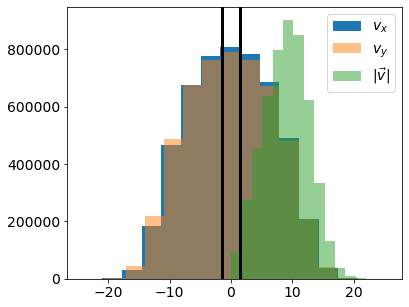

In [20]:
fig, ax = plt.subplots(figsize = (6,5))

bins = 15

ax.hist(v_x, bins = bins, label = r'$v_x$')
ax.hist(v_y, bins = bins, alpha = 0.5, label = r'$v_y$')
ax.hist(np.sqrt(v_x**2+v_y**2), bins = bins, alpha = 0.5, label = r'$|\vec{v}|$')

ax.legend(fontsize = 14)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')
set_fontsize(ax, 14)

This figure shows the transverse velocity spread in the rotational cooling chamber.

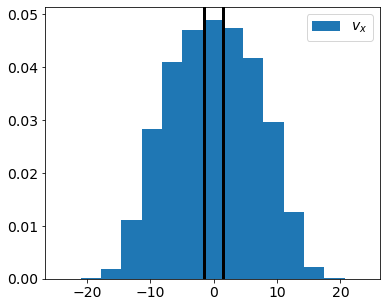

In [21]:
fig, ax = plt.subplots(figsize = (6,5))

bins = 15

ax.hist(v_x, bins = bins, label = r'$v_x$', density=True)

ax.legend(fontsize = 14)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')
set_fontsize(ax, 14)

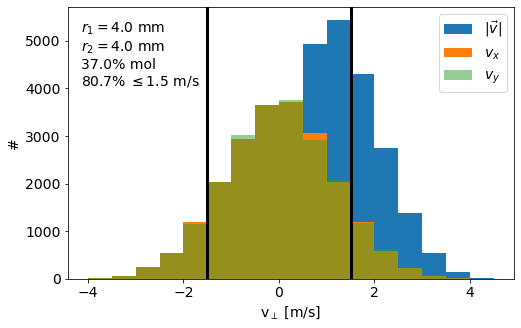

In [22]:
# calculating the velocity spread after 2 apertures
# both with an aperture radius of 4 mm

r1 = 4e-3
r2 = 4e-3

bins = np.arange(-4,4+1,0.5)

fig, ax = plt.subplots(figsize = (8,5))

m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
m  = m1 & m2

ax.hist(np.sqrt(v_x[m]**2+v_y[m]**2), bins = bins, label = r'$|\vec{v}|$')
ax.hist(v_x[m], bins = bins, label = r'$v_x$')
ax.hist(v_y[m], bins = bins, alpha = 0.5, label = r'$v_y$')

ax.legend(fontsize = 14, loc = 1)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')

ax.set_xlabel(r'v$_\perp$ [m/s]')
ax.set_ylabel('#')

set_fontsize(ax, 14)
    
dt = distance_laser_lif/v_z[m]
m_interact = (np.abs(coords[1,:][m]+dt*v_y[m]) <= r_laser) & (np.abs(v_x[m]) <= v_laser)
interact = m_interact.sum()/interaction_lif*100

text = f'$r_1 = ${r1*1e3:.1f} mm'+'\n'
text += f'$r_2 = ${r2*1e3:.1f} mm'+'\n'
text += f'{m.sum()/interaction_lif*100:.1f}% mol'+'\n'
text += f'{(100*(np.abs(v_x[m]) < v_acceptable).sum()/m.sum()):.1f}% $\leq {v_acceptable}$ m/s'
ax.text(0.03, 0.95, text, transform = ax.transAxes,
        ha = 'left', va = 'top', fontsize = 14);

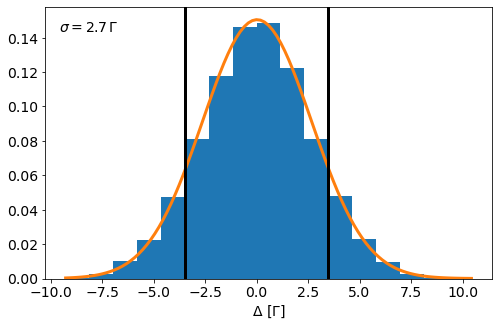

In [23]:
bins = np.arange(-4*v_to_Γ,(4+1)*v_to_Γ,0.5*v_to_Γ)

fig, ax = plt.subplots(figsize = (8,5))

m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
m  = m1 & m2

mask_filtered_beam = m.copy()

ax.hist(v_x[m]*v_to_Γ, bins = bins, label = r'$v_x$', density = True)

mu, sigma = norm.fit(v_x[m]*v_to_Γ)

_x = np.linspace(bins.min(), bins.max(), 101)
ax.plot(_x, norm.pdf(_x, mu, sigma), lw = 3)

ax.axvline(v_acceptable*v_to_Γ, lw = 3, color = 'k')
ax.axvline(-v_acceptable*v_to_Γ, lw = 3, color = 'k')

ax.set_xlabel(r'$\Delta$ [Γ]')
set_fontsize(ax, 14)

text = f'$\sigma = ${sigma:.1f}$\,$Γ'
ax.text(0.03, 0.95, text, transform = ax.transAxes,
        ha = 'left', va = 'top', fontsize = 14);

The transverse velocity spread that makes it to the LIF detection region in units of $\Gamma$.

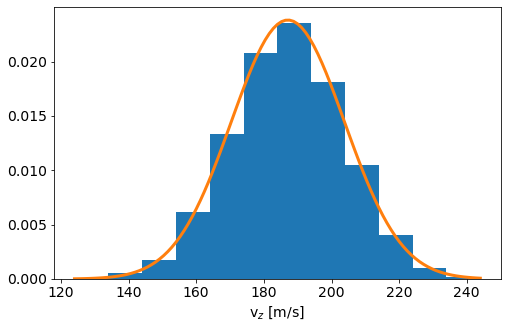

In [24]:
bins = np.linspace(184-60, 184+60, 13)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(v_z[m], density = True, bins = bins)


mu_z, sigma_z = norm.fit(v_z[m])

_z = np.linspace(bins.min(), bins.max(), 101)
ax.plot(_z, norm.pdf(_z, mu_z, sigma_z), lw = 3)


ax.set_xlabel(r'v$_z$ [m/s]')
set_fontsize(ax, 14)

longitudinal velocity spread that makes it to the LIF chamber

# Light Multipass
The multipass spans about 1.25".  
The cylindrically expanded beam is expanded to $5265~\mu$m ($4\sigma$) in height, and $2642~\mu$m ($4\sigma$) in width.

In [25]:
def gaussian(x, μ, σ):
    return np.exp(-(x-μ)**2 / (2 * σ**2))

In [26]:
def gaussian_amp(x, a, μ, σ):
    return a*np.exp(-(x-μ)**2 / (2 * σ**2))

In [27]:
def multipass_prism_order(passes):
    npass = [1]
    for p in range(1,passes):
        if p%2 == 0:
            npass.append(p+1)
        else:
            npass.append(passes-p)
    return npass

In [28]:
nr_passes = 15
beam_spacing = (1.75*units.imperial.inch).to(units.m)/nr_passes
beam_locs = np.array([i*beam_spacing.value for i in range(nr_passes)]) + 0.005

In [29]:
σzlaser = 2642*1e-6/4 # σ width of the laser.
σylaser = 5265*1e-6/4 # σ height of the laser

In [30]:
_z = np.linspace(0,beam_locs.max()+2*beam_spacing.value,501)

In [31]:
reflections = (np.array(multipass_prism_order(15))-1)
loss = 0.04 # reflection loss per pass
amplitudes = np.array([(1-loss)**r for r in reflections])

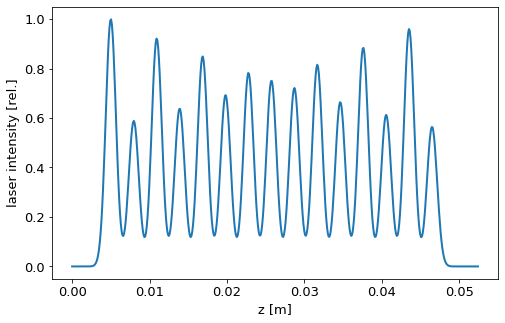

In [32]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(_z, gaussian_amp(_z[:,np.newaxis], amplitudes[np.newaxis, :], beam_locs[np.newaxis, :], σzlaser).sum(axis = 1), lw = 2)

ax.set_xlabel('z [m]')
ax.set_ylabel('laser intensity [rel.]')

set_fontsize(ax, 13)

In [33]:
def gaussian_2d(y,z,μy,μz,σy,σz):
    a = (y-μy)**2/(2*σy**2)
    b = (z-μz)**2/(2*σz**2)
    return np.exp(-(a+b))

In [34]:
def gaussian_2d_amp(a,y,z,μy,μz,σy,σz):
    return a*gaussian_2d(y,z,μy,μz,σy,σz)

In [35]:
yi = np.linspace(-5,5,201)*σylaser
zi = np.linspace(0,0.05,1001)
Y,Z = np.meshgrid(yi,zi)

In [36]:
gaussian_amp(_z[:,np.newaxis], amplitudes[np.newaxis, :], beam_locs[np.newaxis, :], σzlaser).sum(axis = 1).shape

(501,)

<ipython-input-37-9ca129b83bef>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(Z.T*1e3,Y.T*1e3,intensity_multipass.T)


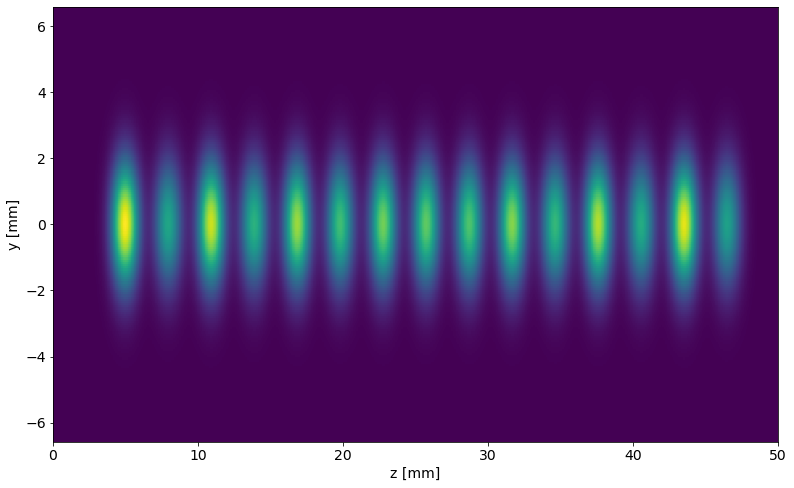

In [37]:
intensity_multipass = gaussian_2d_amp(amplitudes[np.newaxis,:], 
                                      Y[:,:,np.newaxis], Z[:,:,np.newaxis], 
                                      0,  beam_locs[np.newaxis, :], 
                                      σylaser, σzlaser).sum(axis = 2)

fig, ax = plt.subplots(figsize = (13,8))
ax.pcolormesh(Z.T*1e3,Y.T*1e3,intensity_multipass.T)

ax.set_xlabel('z [mm]')
ax.set_ylabel('y [mm]')

set_fontsize(ax, 14)

## Running in Julia

In [38]:
Main.eval("""using Waveforms""")
Main.eval("""using DifferentialEquations""")
Main.eval("""using BenchmarkTools""")
Main.eval("""
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())
""")

<PyCall.jlwrap Logging.ConsoleLogger(Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000830) open, 0 bytes waiting), Info, Logging.default_metafmt, true, 0, Dict{Any,Int64}())>

In [39]:
Main.eval("""
function square_wave(t::Float64, frequency::Float64, phase::Float64)
    0.5.*(1 .+ squarewave(2*pi.*frequency.*t .+ phase))
end
""")

<PyCall.jlwrap square_wave>

In [40]:
Main.eval("""
function gaussian_2d(x::Float64, y::Float64, a::Float64, μx::Float64, μy::Float64, σx::Float64, σy::Float64)::Float64
    a.*exp(.- ((x.-μx).^2 ./ (2 .* σx.*σx) + (y.-μy).^2 ./ (2 .* σy.*σy)))
end
""")

<PyCall.jlwrap gaussian_2d>

In [41]:
# assuming the laser beam is centered, e.g. μy = 0
Main.eval("""
function multipass_2d_intensity(x::Float64, y::Float64, amplitudes, locations, σx::Float64, σy::Float64)::Float64
    intensity::Float64 = 0.0
    for i = 1:length(amplitudes)
        @inbounds intensity += gaussian_2d(x,y,amplitudes[i],locations[i],0.0, σx,σy)
    end
    return intensity
end
""")

<PyCall.jlwrap multipass_2d_intensity>

In [42]:
Main.amplitudes = amplitudes
Main.beam_locs = beam_locs
Main.σylaser = σylaser
Main.σzlaser = σzlaser

In [43]:
Main.eval("typeof(Main.beam_locs)")

<PyCall.jlwrap Array{Float64,1}>

In [44]:
Main.eval("""
@time multipass_2d_intensity(0.04,0.,amplitudes,beam_locs,σzlaser, σylaser)
""")

0.42890221590688876

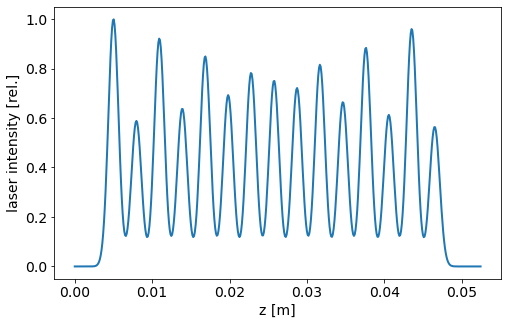

In [45]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(_z, [Main.multipass_2d_intensity(zi, 0., amplitudes, beam_locs, σzlaser, σzlaser) for zi in _z], lw = 2)

ax.set_xlabel('z [m]')
ax.set_ylabel('laser intensity [rel.]')

set_fontsize(ax, 14)

In [46]:
# reading from file
with open('ode_fun_Rabi_real.jl', 'r', encoding='utf8') as f:
    ode_fun = f.read()

In [47]:
print(ode_fun[:170])


function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ω = p[1]
		νp = p[2]
		Δ = p[3]
		Px = square_wave(t, νp, 3.141592653589793)
		Pz = square_wave(t, νp, 0.0)    
		


In [48]:
Main.eval(ode_fun.replace("Lindblad_rhs!", "Lindblad_rhs_cstfield!"))

<PyCall.jlwrap Lindblad_rhs_cstfield!>

In [49]:
ode_fun_new = """
function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tνp = p[2]
\t\tΔ = p[3]
\t\tvz = p[4]
\t\tvy = p[5]
\t\ty0 = p[6]
\t\tσzlaser = p[7]
\t\tσylaser = p[8]
\t\tn_passes = floor(Int8,p[9])
\t\tΩ = p[1]*multipass_2d_intensity(vz*t, y0+vy*t, p[10:10+n_passes], p[10+n_passes:end], σzlaser, σylaser)
\t\tPx = square_wave(t, νp, 3.141592653589793)
\t\tPz = square_wave(t, νp, 0.0)    
"""

Easy to modify function
```Julia
function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		νp = p[2]
		Δ = p[3]
		v = p[4]
		σlaser = p[5]
		n_passes = floor(Int8,p[6])
		Ω = p[1]*multipass_intensity(v*t, p[7:7+n_passes], p[7+n_passes:end], σlaser)
		Px = square_wave(t, νp, 3.141592653589793)
		Pz = square_wave(t, νp, 0.0)
        du[1,1] = 3367347.38920463*ρ[37,37] + 3367525.85757619*ρ[38,38] + 3367704.32982946*ρ[39,39]
```

In [50]:
ode_fun_new += ode_fun[170:]
print(ode_fun_new[:1116])


function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		νp = p[2]
		Δ = p[3]
		vz = p[4]
		vy = p[5]
		y0 = p[6]
		σzlaser = p[7]
		σylaser = p[8]
		n_passes = floor(Int8,p[9])
		Ω = p[1]*multipass_2d_intensity(vz*t, y0+vy*t, p[10:10+n_passes], p[10+n_passes:end], σzlaser, σylaser)
		Px = square_wave(t, νp, 3.141592653589793)
		Pz = square_wave(t, νp, 0.0)    
du[1,1] = 3367347.38920463*ρ[37,37] + 3367525.85757619*ρ[38,38] + 3367704.32982946*ρ[39,39]
		du[1,2] = -83545.9813842773*1im*ρ[1,2]
		du[1,3] = -83566.3651428223*1im*ρ[1,3]
		du[1,4] = -83586.7483215332*1im*ρ[1,4]
		du[1,5] = 83783184618.4029*1im*ρ[1,5]
		du[1,6] = 83783324359.4973*1im*ρ[1,6]
		du[1,7] = 83783324348.7985*1im*ρ[1,7]
		du[1,8] = 83783324338.0963*1im*ρ[1,8]
		du[1,9] = 83784429890.3703*1im*ρ[1,9]
		du[1,10] = 83784429890.5489*1im*ρ[1,10]
		du[1,11] = 83784429890.728*1im*ρ[1,11]
		du[1,12] = 83784521261.0184*1im*ρ[1,12]
		du[1,13] = 83784521250.7175*1im*ρ[1,13]
		du[1,14] = 83784521240.416*1im*ρ[1,14]
		du[1,15] = 8

In [51]:
# defining the function in Julia
Main.eval(ode_fun_new)

<PyCall.jlwrap Lindblad_rhs!>

Loading initial population at 7 K

In [52]:
data_dir = Path('stored_data')

fnames = ['rho_ini']

for fname in fnames:
    if fname == 'rho_ini':
        ρ_ini = np.load(data_dir / (fname + '.npy'))
    else:
        globals()[fname] = np.load(data_dir / (fname + '.npy'))

In [54]:
de_main = -0.39444661382277774 # main dipole transition moment
Γ = 1/(100e-9)
Ω =  4.5*Γ*abs(de_main)
ωp = Γ
νp = ωp/(2*np.pi)
Δ = -4*Γ

Main.Ω = Ω
Main.νp = νp
Main.Δ = Δ
Main.Γ = Γ

Main.ρ_ini = ρ_ini
Main.vz = 200.
Main.vy = 1.

Main.n_passes = len(amplitudes)
Main.eval("p = [Ω, νp, Δ, vz, vy, 0., σzlaser, σylaser, n_passes]")
Main.eval("append!(p, amplitudes)")
Main.eval("append!(p, beam_locs)")

array([ 1.77500976e+07,  1.59154943e+06, -4.00000000e+07,  2.00000000e+02,
        1.00000000e+00,  0.00000000e+00,  6.60500000e-04,  1.31625000e-03,
        1.50000000e+01,  1.00000000e+00,  5.88201367e-01,  9.21600000e-01,
        6.38239331e-01,  8.49346560e-01,  6.92533996e-01,  7.82757790e-01,
        7.51447478e-01,  7.21389579e-01,  8.15372698e-01,  6.64832636e-01,
        8.84736000e-01,  6.12709757e-01,  9.60000000e-01,  5.64673312e-01,
        5.00000000e-03,  7.96333333e-03,  1.09266667e-02,  1.38900000e-02,
        1.68533333e-02,  1.98166667e-02,  2.27800000e-02,  2.57433333e-02,
        2.87066667e-02,  3.16700000e-02,  3.46333333e-02,  3.75966667e-02,
        4.05600000e-02,  4.35233333e-02,  4.64866667e-02])

In [55]:
Main.eval("""
_p = [Ω,νp,Δ]
tmp = zeros(ComplexF64,39,39)
Lindblad_rhs_cstfield!(tmp, ρ_ini, _p, 1e-6)
@btime Lindblad_rhs_cstfield!(tmp, ρ_ini, _p, 1e-6)
tmp = 0
""")

0

Function evaluates in about 4.928 $\mu$seconds on my home pc

In [56]:
Main.eval("""
tmp = zeros(ComplexF64,39,39)
Lindblad_rhs!(tmp, ρ_ini, p, 1e-6)
@btime Lindblad_rhs!(tmp, ρ_ini, p, 1e-6)
tmp = 0
""")

0

With the position dependent light intensity the execution time is 5.233 $\mu$seconds

## Single pass first
Setup a callback to stop solver when it reaches a certain position, in this case the end of the multi pass

In [57]:
Main.eval("""
condition(u,t,integrator) = integrator.p[4]*t > 0.05
affect!(integrator) = terminate!(integrator)
cb = DiscreteCallback(condition, affect!)
""")

<PyCall.jlwrap DiscreteCallback{typeof(condition),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT)}(condition, affect!, DiffEqBase.INITIALIZE_DEFAULT, Bool[1, 1])>

In [58]:
Main.eval("""
tspan = (0.0f0, 500e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [59]:
Main.eval("""
@time sol = solve(prob,Tsit5(),callback=cb)
tmp = 0
""")

0

In [60]:
Main.eval('typeof(vy)')

<PyCall.jlwrap Float64>

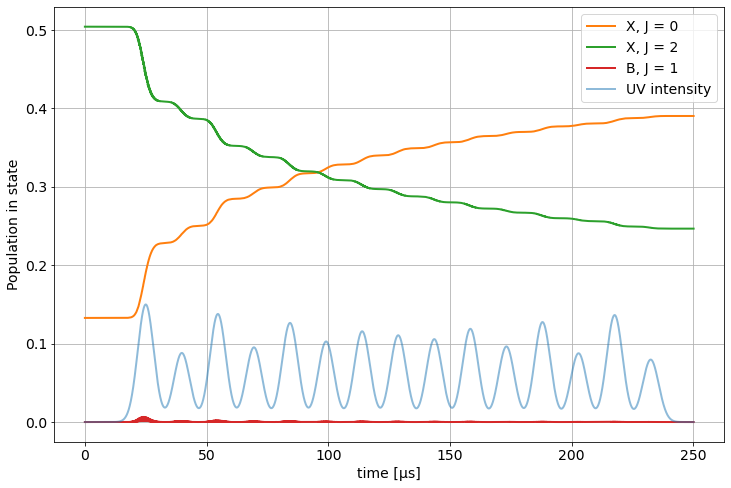

In [62]:
v = Main.vz

ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("""sol.t""").copy()

t_array

#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t_array*1e6, P0, label = 'X, J = 0', lw = 2, color = 'C1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2', lw = 2, color = 'C2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1', lw = 2, color = 'C3')


ax.plot(t_array*1e6, [0.15*Main.multipass_2d_intensity(Main.vz*ti, Main.vy*ti, amplitudes, beam_locs, σzlaser, σzlaser) for ti in t_array], 
        lw = 2, color = 'C0', alpha = 0.5, label = 'UV intensity')

ax.legend(fontsize = 14)
ax.set_xlabel('time [μs]', fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)

## Defining a parameter sweep of Ω, Γ and $v_z$, $v_y$ from the distribution
$v_z$, $v_x$, $v_y$ and $y_0$ are coupled from the extended beamsource calculation

In [63]:
# multipass length ~ 1.5"
distance_laser_rc = (21.75-0.75) * in_to_m - 0.01
dt = distance_laser_rc/v_z

y0 = (coords[1,:]+dt*v_y)[mask_filtered_beam]

In [105]:
trajectories = 10000
Main.eval("Omegas = (Ω/4.5)*(1:1:6)")
Main.Deltas = v_x[mask_filtered_beam][:trajectories]*v_to_Γ*Γ
Main.vzs = v_z[mask_filtered_beam][:trajectories]
Main.vys = v_y[mask_filtered_beam][:trajectories]
Main.y0s = y0[:trajectories]

In [106]:
params = np.empty([len(Main.Omegas)*trajectories,5])
params[:,0] = np.repeat(Main.Omegas, trajectories)
params[:,1:] = np.tile(np.array([Main.Deltas, Main.vzs, Main.vys, Main.y0s]), len(Main.Omegas)).T
Main.params = params
Main.params.shape

(60000, 5)

In [107]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.60433960315e9, 1.60433960315e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000830) open, 0 bytes waiting), 0, 0, 0)>

In [108]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [109]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
function prob_func(prob,i,repeat)
    remake(prob,p=[params[i,1]; νp; params[i,2]; params[i,3]; params[i,4]; params[i,5]; σzlaser; σylaser; n_passes; amplitudes; beam_locs])
end
""")

<PyCall.jlwrap prob_func>

In [110]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [111]:
# making sure multiple threads are enabled
Main.eval("Threads.nthreads()")

10

In [112]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4, callback = cb)
sim.elapsedTime
""")

2656.592708701

In [113]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [114]:
# putting the results into a single numpy array
results_array = np.zeros([len(ens_u),5+39])

for idx, ((Ω_factor, Δ_factor, vz_factor, vy_factor, y0_factor), ut_ens) in tqdm(enumerate(zip(Main.params,ens_u)), total = len(ens_u)):
    results_array[idx,:] = [Ω_factor, Δ_factor, vz_factor, vy_factor, y0_factor] + list(ut_ens)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 82542.51it/s]


In [115]:
fname = 'laser_only_rc_pol_switching_on_apertures_2020_10_28'
np.save(fname, results_array)

In [116]:
fname = 'laser_only_rc_pol_switching_on_apertures_2020_10_28'
results_array = np.load(fname+'.npy')

In [117]:
# for making Ω slices I round Ω_factor to two digits to preven any floating point issues
# keep in mind when the desired spacing is less than two digits to remove rounding or 
# increase the digits
results_array_J0 = np.zeros([len(results_array),6])
for idx, (Ω_factor, Δ_factor, vz_factor, vy_factor, y0_factor, *pops) in tqdm(enumerate(results_array), total = len(results_array)):
    results_array_J0[idx,:] = [round(Ω_factor/Γ/abs(de_main),2), Δ_factor/Γ, vz_factor, vy_factor, y0_factor, np.sum(pops[:4])]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:01<00:00, 39384.62it/s]


In [118]:
P0_ini = np.diag(ρ_ini[:4,:4]).sum().real

for Ω_factor in np.unique(results_array_J0[:,0]):
    m = results_array_J0[:,0] == Ω_factor
    mean_population = np.mean(results_array_J0[m][:,-1])/P0_ini
    mean_err_population = np.std(results_array_J0[m][:,-1]/P0_ini)/np.sqrt(trajectories)
    print(f'Ω : {Ω_factor:.1f} -> ratio = {mean_population:.3f} +/- {mean_err_population:.3f}')

Ω : 1.0 -> ratio = 1.791 +/- 0.006
Ω : 2.0 -> ratio = 2.341 +/- 0.008
Ω : 3.0 -> ratio = 2.651 +/- 0.008
Ω : 4.0 -> ratio = 2.843 +/- 0.007
Ω : 5.0 -> ratio = 2.971 +/- 0.007
Ω : 6.0 -> ratio = 3.059 +/- 0.006


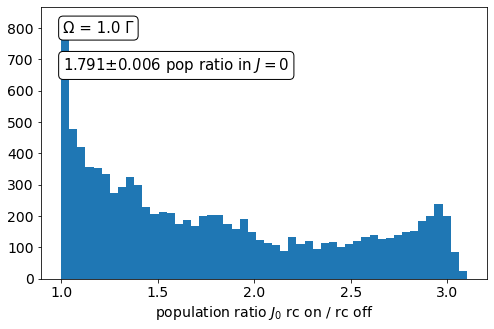

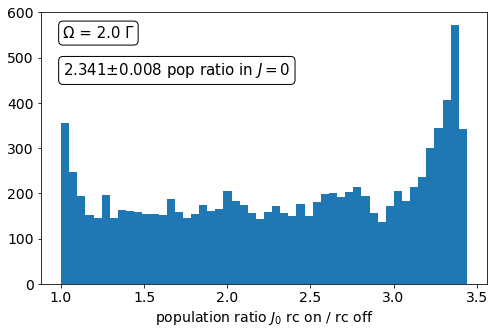

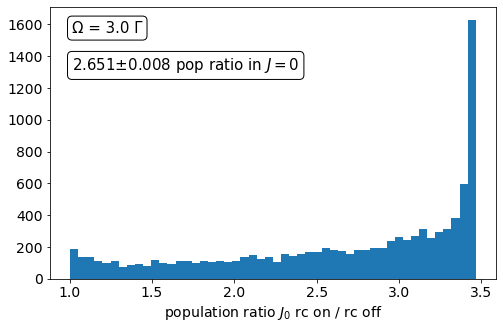

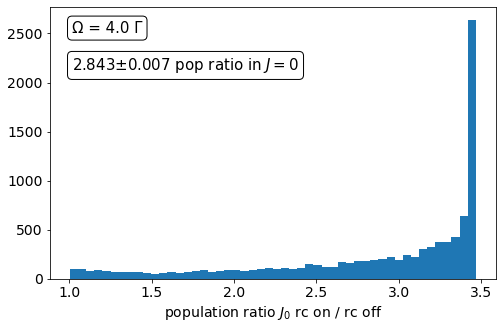

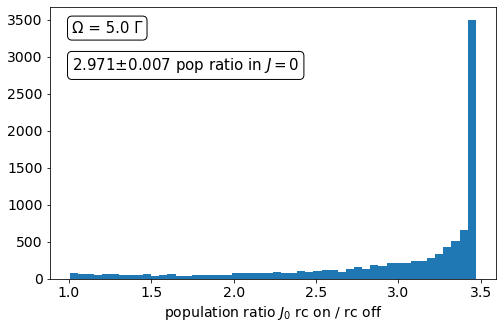

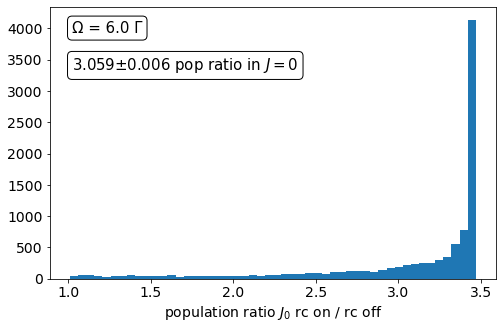

In [119]:
for Ω_factor in np.unique(results_array_J0[:,0]):
    m = results_array_J0[:,0] == Ω_factor
    dat = results_array_J0Γ-1]/P0_ini
    fig, ax = plt.subplots(figsize = (8,5))
    ax.hist(dat, bins = 50)
    ax.set_xlabel(f'population ratio $J_0$ rc on / rc off')
    set_fontsize(ax, 14)
    
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    
    text = f"{np.mean(dat):.3f}$\pm${np.std(dat)/np.sqrt(len(dat)):.3f} pop ratio in $J=0$"
    ax.text(0.05, 0.75, text, transform = ax.transAxes, fontsize = 15, bbox = props,
            va = 'bottom', ha = 'left')
    
    text = f"Ω = {Ω_factor:.1f} Γ"
    ax.text(0.05, 0.95, text, transform = ax.transAxes, fontsize = 15, bbox = props,
            va = 'top', ha = 'left')

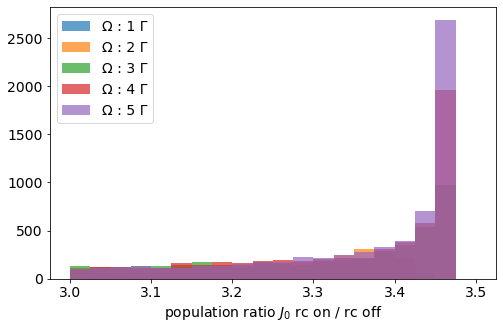

In [120]:
bins = np.linspace(3,3.5,21)

fig, ax = plt.subplots(figsize = (8,5))

for Ω_factor in np.unique(results_array_J0[:,0])[:5]:
    m = results_array_J0[:,0] == Ω_factor
    dat = results_array_J0[m][:,-1]/P0_ini
    ax.hist(dat, bins = bins, label = f'Ω : {Ω_factor:.0f} Γ', alpha = 0.7)
    ax.set_xlabel(f'population ratio $J_0$ rc on / rc off')
    set_fontsize(ax, 14)
ax.legend(fontsize = 14)

## No Polarization Switching, only single polarization used

In [122]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
function prob_func(prob,i,repeat)
    remake(prob,p=[params[i,1]; 0.0; params[i,2]; params[i,3]; params[i,4]; params[i,5]; σzlaser; σylaser; n_passes; amplitudes; beam_locs])
end
""")

<PyCall.jlwrap prob_func>

In [123]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [124]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4, callback = cb)
sim.elapsedTime
""")

1311.0277339

In [125]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [126]:
# putting the results into a single numpy array
results_array = np.zeros([len(ens_u),5+39])

for idx, ((Ω_factor, Δ_factor, vz_factor, vy_factor, y0_factor), ut_ens) in tqdm(enumerate(zip(Main.params,ens_u)), total = len(ens_u)):
    results_array[idx,:] = [Ω_factor, Δ_factor, vz_factor, vy_factor, y0_factor] + list(ut_ens)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 73316.06it/s]


In [127]:
fname = 'laser_only_rc_pol_switching_off_apertures_2020_10_28'
np.save(fname, results_array)

In [128]:
fname = 'laser_only_rc_pol_switching_off_apertures_2020_10_28'
results_array = np.load(fname+'.npy')

In [129]:
# for making Ω slices I round Ω_factor to two digits to preven any floating point issues
# keep in mind when the desired spacing is less than two digits to remove rounding or 
# increase the digits
results_array_J0 = np.zeros([len(results_array),6])
for idx, (Ω_factor, Δ_factor, vz_factor, vy_factor, y0_factor, *pops) in tqdm(enumerate(results_array), total = len(results_array)):
    results_array_J0[idx,:] = [round(Ω_factor/Γ/abs(de_main),2), Δ_factor/Γ, vz_factor, vy_factor, y0_factor, np.sum(pops[:4])]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:01<00:00, 43644.41it/s]


In [130]:
P0_ini = np.diag(ρ_ini[:4,:4]).sum().real

for Ω_factor in np.unique(results_array_J0[:,0]):
    m = results_array_J0[:,0] == Ω_factor
    mean_population = np.mean(results_array_J0[m][:,-1])/P0_ini
    mean_err_population = np.std(results_array_J0[m][:,-1]/P0_ini)/np.sqrt(trajectories)
    print(f'Ω : {Ω_factor:.1f} -> ratio = {mean_population:.3f} +/- {mean_err_population:.3f}')

Ω : 1.0 -> ratio = 1.572 +/- 0.003
Ω : 2.0 -> ratio = 1.787 +/- 0.003
Ω : 3.0 -> ratio = 1.884 +/- 0.003
Ω : 4.0 -> ratio = 1.934 +/- 0.002
Ω : 5.0 -> ratio = 1.963 +/- 0.002
Ω : 6.0 -> ratio = 1.980 +/- 0.002


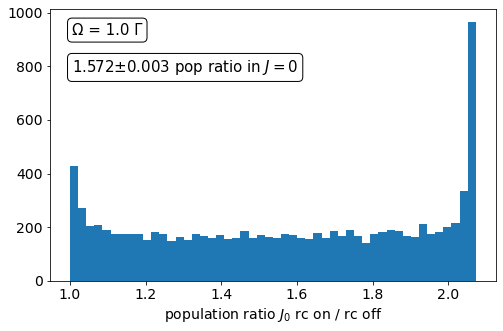

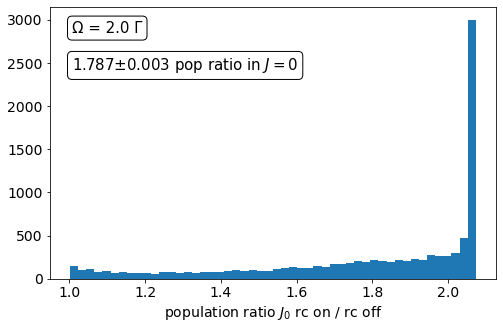

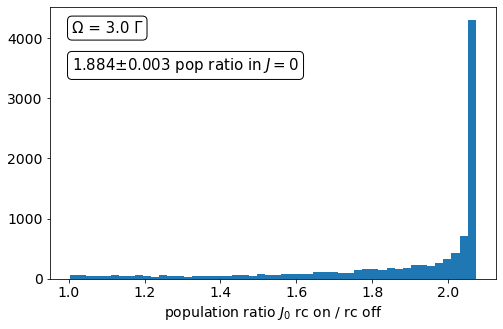

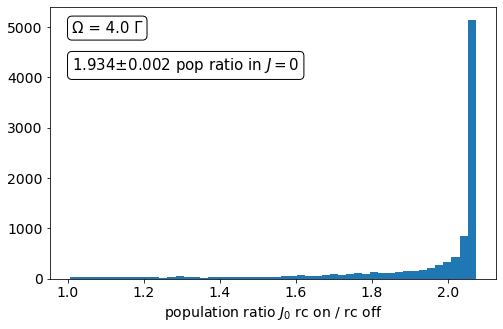

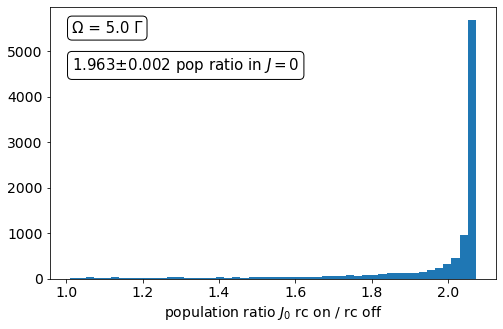

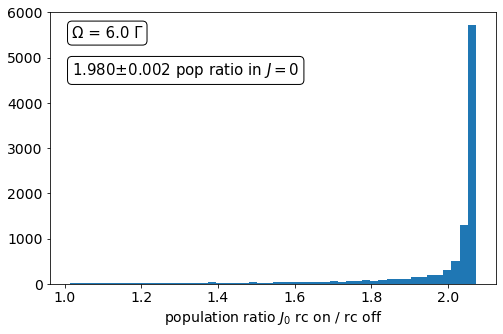

In [131]:
for Ω_factor in np.unique(results_array_J0[:,0]):
    m = results_array_J0[:,0] == Ω_factor
    dat = results_array_J0[m][:,-1]/P0_ini
    fig, ax = plt.subplots(figsize = (8,5))
    ax.hist(dat, bins = 50)
    ax.set_xlabel(f'population ratio $J_0$ rc on / rc off')
    set_fontsize(ax, 14)
    
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    
    text = f"{np.mean(dat):.3f}$\pm${np.std(dat)/np.sqrt(len(dat)):.3f} pop ratio in $J=0$"
    ax.text(0.05, 0.75, text, transform = ax.transAxes, fontsize = 15, bbox = props,
            va = 'bottom', ha = 'left')
    
    text = f"Ω = {Ω_factor:.1f} Γ"
    ax.text(0.05, 0.95, text, transform = ax.transAxes, fontsize = 15, bbox = props,
            va = 'top', ha = 'left')

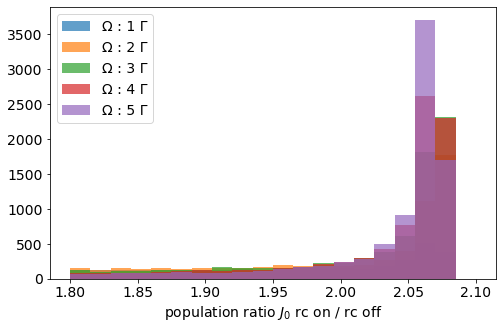

In [132]:
bins = np.linspace(1.8,2.1,21)

fig, ax = plt.subplots(figsize = (8,5))

for Ω_factor in np.unique(results_array_J0[:,0])[:5]:
    m = results_array_J0[:,0] == Ω_factor
    dat = results_array_J0[m][:,-1]/P0_ini
    ax.hist(dat, bins = bins, label = f'Ω : {Ω_factor:.0f} Γ', alpha = 0.7)
    ax.set_xlabel('population ratio $J_0$ rc on / rc off')
    set_fontsize(ax, 14)
ax.legend(fontsize = 14)

## Misalignment of RC beam

In [133]:
# multipass length ~ 1.5"
distance_laser_rc = (21.75-0.75) * in_to_m - 0.01
dt = distance_laser_rc/v_z

y0 = (coords[1,:]+dt*v_y)[mask_filtered_beam]

In [134]:
trajectories = 1000
Main.eval("Omegas = (Ω/4.5)*(1:1:6)")
Main.Deltas = v_x[mask_filtered_beam][:trajectories]*v_to_Γ*Γ
Main.vzs = v_z[mask_filtered_beam][:trajectories]
Main.vys = v_y[mask_filtered_beam][:trajectories]
Main.y0s = y0[:trajectories]
Main.heights = np.arange(1,3.1,0.5)*1e-3

In [135]:
Ω_nr = len(Main.Omegas)
h_nr = len(Main.heights)
params = np.zeros([Ω_nr*h_nr*trajectories,6])
params[:,0] = np.repeat(Main.Omegas, h_nr*trajectories)
params[:,1] = np.tile(np.tile(Main.heights, Ω_nr), trajectories)
params[:,2:] = np.repeat(np.array([Main.Deltas, Main.vzs, Main.vys, Main.y0s]), Ω_nr*h_nr, axis = 1).T
Main.params = params

In [136]:
# assuming the laser beam is centered, e.g. μy = 0
Main.eval("""
function multipass_2d_intensity(x::Float64, y::Float64, amplitudes, locations, yloc::Float64, σx::Float64, σy::Float64)::Float64
    intensity::Float64 = 0.0
    for i = 1:length(amplitudes)
        @inbounds intensity += gaussian_2d(x,y,amplitudes[i],locations[i],yloc, σx,σy)
    end
    return intensity
end
""")

<PyCall.jlwrap multipass_2d_intensity>

In [137]:
ode_fun_yloc = """
function Lindblad_rhs_yloc!(du, ρ, p, t)
\t@inbounds begin
\t\tνp = p[2]
\t\tΔ = p[3]
\t\tvz = p[4]
\t\tvy = p[5]
\t\ty0 = p[6]
\t\tσzlaser = p[7]
\t\tσylaser = p[8]
\t\tmultiy = p[9]
\t\tn_passes = floor(Int8,p[10])
\t\tΩ = p[1]*multipass_2d_intensity(vz*t, y0+vy*t, p[11:11+n_passes], p[11+n_passes:end], multiy, σzlaser, σylaser)
\t\tPx = square_wave(t, νp, 3.141592653589793)
\t\tPz = square_wave(t, νp, 0.0)    
"""

In [138]:
ode_fun_yloc += ode_fun[170:]
# defining the function in Julia
Main.eval(ode_fun_yloc)

<PyCall.jlwrap Lindblad_rhs_yloc!>

In [139]:
Main.eval("p = [Ω, νp, Δ, vz, vy, 0., σzlaser, σylaser, 1e-3, n_passes]")
Main.eval("append!(p, amplitudes)")
Main.eval("append!(p, beam_locs)")
Main.eval("""
tspan = (0.0f0, 500e-6)
prob = ODEProblem(Lindblad_rhs_yloc!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [140]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.604347290834e9, 1.604347290834e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000830) open, 0 bytes waiting), 0, 0, 0)>

In [141]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [142]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
function prob_func(prob,i,repeat)
    remake(prob,p=[params[i,1]; νp; params[i,3]; params[i,4]; params[i,5]; params[i,6]; σzlaser; σylaser; params[i,2]; n_passes; amplitudes; beam_locs])
end
""")

<PyCall.jlwrap prob_func>

In [143]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [144]:
# making sure multiple threads are enabled
Main.eval("Threads.nthreads()")

10

In [145]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4, callback = cb)
sim.elapsedTime
""")

1248.6293749

In [146]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [147]:
# putting the results into a single numpy array
results_array = np.zeros([len(ens_u),6+39])

for idx, ((Ω_factor, h_factor, Δ_factor, vz_factor, vy_factor, y0_factor), ut_ens) in tqdm(enumerate(zip(Main.params,ens_u)), total = len(ens_u)):
    results_array[idx,:] = [Ω_factor, h_factor, Δ_factor, vz_factor, vy_factor, y0_factor] + list(ut_ens)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:00<00:00, 82264.81it/s]


In [148]:
fname = 'laser_only_rc_pol_switching_on_multipass_height_apertures_2020_10_28'
np.save(fname, results_array)

In [149]:
fname = 'laser_only_rc_pol_switching_on_multipass_height_apertures_2020_10_28'
results_array = np.load(fname+'.npy')

In [150]:
# for making Ω slices I round Ω_factor to two digits to preven any floating point issues
# keep in mind when the desired spacing is less than two digits to remove rounding or 
# increase the digits
results_array_J0 = np.zeros([len(results_array),7])
for idx, (Ω_factor, h_factor, Δ_factor, vz_factor, vy_factor, y0_factor, *pops) in tqdm(enumerate(results_array), total = len(results_array)):
    results_array_J0[idx,:] = [round(Ω_factor/Γ/abs(de_main),2), h_factor, Δ_factor/Γ, vz_factor, vy_factor, y0_factor, np.sum(pops[:4])]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:00<00:00, 46756.79it/s]


In [151]:
P0_ini = np.diag(ρ_ini[:4,:4]).sum().real

for Ω_factor in np.unique(results_array_J0[:,0]):
    for h_factor in np.unique(results_array_J0[:,1]):
        m = (results_array_J0[:,0] == Ω_factor) & (results_array_J0[:,1] == h_factor)
        mean_population = np.mean(results_array_J0[m][:,-1])/P0_ini
        mean_err_population = np.std(results_array_J0[m][:,-1]/P0_ini)/np.sqrt(trajectories)
        print(f'Ω : {Ω_factor:.1f}; h : {h_factor:.1e} -> ratio = {mean_population:.3f} +/- {mean_err_population:.3f}')

Ω : 1.0; h : 1.0e-03 -> ratio = 1.713 +/- 0.020
Ω : 1.0; h : 1.5e-03 -> ratio = 1.617 +/- 0.020
Ω : 1.0; h : 2.0e-03 -> ratio = 1.503 +/- 0.020
Ω : 1.0; h : 2.5e-03 -> ratio = 1.390 +/- 0.019
Ω : 1.0; h : 3.0e-03 -> ratio = 1.285 +/- 0.017
Ω : 2.0; h : 1.0e-03 -> ratio = 2.280 +/- 0.026
Ω : 2.0; h : 1.5e-03 -> ratio = 2.124 +/- 0.028
Ω : 2.0; h : 2.0e-03 -> ratio = 1.936 +/- 0.028
Ω : 2.0; h : 2.5e-03 -> ratio = 1.730 +/- 0.026
Ω : 2.0; h : 3.0e-03 -> ratio = 1.521 +/- 0.023
Ω : 3.0; h : 1.0e-03 -> ratio = 2.556 +/- 0.028
Ω : 3.0; h : 1.5e-03 -> ratio = 2.382 +/- 0.029
Ω : 3.0; h : 2.0e-03 -> ratio = 2.167 +/- 0.030
Ω : 3.0; h : 2.5e-03 -> ratio = 1.932 +/- 0.030
Ω : 3.0; h : 3.0e-03 -> ratio = 1.703 +/- 0.028
Ω : 4.0; h : 1.0e-03 -> ratio = 2.634 +/- 0.026
Ω : 4.0; h : 1.5e-03 -> ratio = 2.440 +/- 0.030
Ω : 4.0; h : 2.0e-03 -> ratio = 2.227 +/- 0.032
Ω : 4.0; h : 2.5e-03 -> ratio = 2.014 +/- 0.032
Ω : 4.0; h : 3.0e-03 -> ratio = 1.801 +/- 0.030
Ω : 5.0; h : 1.0e-03 -> ratio = 2.708 +/

In [152]:
P0_ini = np.diag(ρ_ini[:4,:4]).sum().real
h_factor = 1e-3

for Ω_factor in np.unique(results_array_J0[:,0]):
    m = (results_array_J0[:,0] == Ω_factor) & (results_array_J0[:,1] == h_factor)
    mean_population = np.mean(results_array_J0[m][:,-1])/P0_ini
    mean_err_population = np.std(results_array_J0[m][:,-1]/P0_ini)/np.sqrt(trajectories)
    print(f'Ω : {Ω_factor:.1f}; h : {h_factor:.1e} -> ratio = {mean_population:.3f} +/- {mean_err_population:.3f}')

Ω : 1.0; h : 1.0e-03 -> ratio = 1.713 +/- 0.020
Ω : 2.0; h : 1.0e-03 -> ratio = 2.280 +/- 0.026
Ω : 3.0; h : 1.0e-03 -> ratio = 2.556 +/- 0.028
Ω : 4.0; h : 1.0e-03 -> ratio = 2.634 +/- 0.026
Ω : 5.0; h : 1.0e-03 -> ratio = 2.708 +/- 0.027
Ω : 6.0; h : 1.0e-03 -> ratio = 2.805 +/- 0.026
